<a href="https://colab.research.google.com/github/TheGooseGuy/Insurance-Product-Prediction/blob/main/Data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Stephen Torku, Zikang Ge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV

pd.set_option('display.precision', 2)                     # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation
plt.style.use('seaborn-v0_8')                             # pretty matplotlib plots

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_excel("/content/drive/MyDrive/6100 Project2 DATA/Project2_Training.xlsx") # Read training data set
test = pd.read_excel("/content/drive/MyDrive/6100 Project2 DATA/Project2_Test.xlsx") # Read testing data set

In [149]:
train_data = train.copy()
test_data = test.copy()

# Data Pre-processing

In [150]:
# Rename test data columns to match train data
test_data.rename(columns={
    'ANNUALKM': 'ANNUAL_KM',
    'COMMUTEDISTANCE': 'COMMUTE_DISTANCE',
    'MARKINGSYSTEM': 'MARKING_SYSTEM',
    'TRACKINGSYSTEM': 'TRACKING_SYSTEM',
    'VEHICLEOWNERSHIP': 'VEHICLE_OWNERSHIP',
    'VEHICLEVALUE': 'VEHICLE_VALUE',
    'YEAROFBIRTH': 'YEAR_OF_BIRTH',
    'POSTALCODE': 'POSTAL_CODE',
    'AREACODE': 'AREA_CODE',
    'YEARSLICENSED': 'YEARS_LICENSED',
    'YEARSASPRINCIPALDRIVER': 'YEARS_AS_PRINCIPAL_DRIVER',
    'MULTIPRODUCT': 'MULTI_PRODUCT',
    'MARITALSTATUS': 'MARITAL_STATUS',
    'CONVICTIONCOUNTMINOR3YRS': 'CONVICTION_COUNT_MINOR_3YRS',
    'CONVICTIONCOUNTMAJOR3YRS': 'CONVICTION_COUNT_MAJOR_3YRS',
    'CONVICTIONCOUNTCRIMINAL3YRS': 'CONVICTION_COUNT_CRIMINAL_3YRS',
    'ASSIGNEDLOSSESPD5YRS': 'ASSIGNED_LOSSES_PD_5YRS',
    'SUSPENSIONCOUNT': 'SUSPENSION_COUNT',}, inplace=True)

In [151]:
# Check for NA values in each column
for column in train_data.columns:
    if train_data[column].isna().sum() > 0:
        print(f"{column} has {train_data[column].isna().sum()} missing values.")
print("")
for column in test_data.columns:
    if test_data[column].isna().sum() > 0:
        print(f"{column} has {test_data[column].isna().sum()} missing values.")

ANNUAL_KM has 1 missing values.
COMMUTE_DISTANCE has 35413 missing values.
MARKING_SYSTEM has 101866 missing values.
TRACKING_SYSTEM has 101887 missing values.
VEHICLE_OWNERSHIP has 76450 missing values.
VEHICLE_VALUE has 64673 missing values.
GENDER has 5 missing values.
YEARS_LICENSED has 8 missing values.
YEARS_AS_PRINCIPAL_DRIVER has 101279 missing values.
OCCUPATION has 1 missing values.

COMMUTE_DISTANCE has 5191 missing values.
MARKING_SYSTEM has 15095 missing values.
TRACKING_SYSTEM has 15112 missing values.
VEHICLE_OWNERSHIP has 11500 missing values.
VEHICLE_VALUE has 10159 missing values.
YEARS_LICENSED has 3 missing values.
YEARS_AS_PRINCIPAL_DRIVER has 14946 missing values.


## Data Cleaning & Feature Engineering

In [152]:
# Vehicle_makes
distinct_vehicle_makes = train_data['VEHICLEMODEL'].unique()
print(distinct_vehicle_makes)

print("")

distinct_vehicle_makes = test_data['VEHICLEMAKE'].unique()
print(distinct_vehicle_makes)

['JETTA 2.5 4P' 'ELANTRA GL 4DR' 'SILVERADO 2500 HD LT CREW CAB 4WD' ...
 'SILVERADO 1500 LS DOUBLE CAB 2WD' '500 SPORT 2P' '2.3CL 2DR']

['HONDA' 'FORD TRUCK/VAN' 'DODGE/RAM TRUCK/VAN' 'FORD'
 'CHEVROLET TRUCK/VAN' 'GMC TRUCK/VAN' 'BMW TRUCK/VAN' 'ACURA' 'TOYOTA'
 'TOYOTA TRUCK/VAN' 'CHRYSLER' 'KIA' 'MAZDA TRUCK/VAN' 'CHEVROLET' 'MAZDA'
 'NISSAN TRUCK/VAN' 'MITSUBISHI' 'HYUNDAI TRUCK/VAN' 'PONTIAC'
 'KIA TRUCK/VAN' 'NISSAN' 'LEXUS TRUCK/VAN' 'MERCEDES-BENZ TRUCK'
 'VOLKSWAGEN TRUCK/VAN' 'BUICK' 'VOLKSWAGEN' 'VOLVO' 'MERCEDES-BENZ'
 'HONDA TRUCK/VAN' 'HYUNDAI' 'BMW' 'INFINITI TRUCK/VAN'
 'CADILLAC TRUCK/VAN' 'JEEP' 'HYUNDAI CAMION/VAN' 'MITSUBISHI TRUCK/VAN'
 'BUICK TRUCK/VAN' 'SUBARU' 'FORD CAMION/VAN' 'MERZ' 'LINCOLN TRUCK/VAN'
 'CHRYSLER TRUCK/VAN' 'DODGE' 'PONTIAC TRUCK/VAN' 'LEXUS' 'MERCURY'
 'SATURN TRUCK/VAN' 'OLDSMOBILE' 'AUDI' 'PORSCHE TRUCK/VAN' 'MASERATI'
 'CADILLAC' 'VOLVO TRUCK/VAN' 'AUDI TRUCK/VAN' 'MINI' 'LAND ROVER'
 'ACURA TRUCK/VAN' 'LEXUS CAMION/VAN' 'INFINITI' 'FIAT

In [153]:
# Combine train data and test data, will split them in the end
train_data['is_train'] = 1
test_data['is_train'] = 0

combined_data = pd.concat([train_data, test_data], ignore_index=True)

In [154]:
# QUOTEDATE
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
combined_data['VEHICLE_AGE'] = pd.to_datetime(combined_data['QUOTEDATE']).dt.year - combined_data['VEHICLEYEAR']
combined_data['Season'] = combined_data['QUOTEDATE'].apply(get_season)

# Encode 'Season' using pd.get_dummies
combined_data = pd.get_dummies(combined_data, columns=['Season'], prefix='Season')

# Drop 'Quote_Month' if you no longer need it
combined_data = combined_data.drop(columns=['QUOTEDATE'])

In [155]:
# VEHICLEYEAR

# Group by vehicle age brackets
def vehicle_age_group(year):
    if year < 2000:
        return 'Vintage'
    elif year < 2010:
        return 'Old'
    else:
        return 'Modern'

combined_data['Vehicle_Age_Group'] = combined_data['VEHICLEYEAR'].apply(vehicle_age_group)
combined_data = pd.get_dummies(combined_data, columns=['Vehicle_Age_Group'], prefix='Age')

In [156]:
# Define your regex replacements dictionary
replacements = {
  # Volkswagen variations
  r'\bVW\b|\bWV\b|\bVOLKS\b|VOLKSWAGON|VOLGSWAGEN|VOLSWAGEN|VOLKSWAGENJAVASCRIPT:VOID\(0\)|VOLLKS|VOLKSWAGEN(?:\s+TRUCK/VAN|\s+CAMION/VA)?': 'VOLKSWAGEN',

  # Honda variations
  r'HONDA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|HONODA|HONDA \s*CIVIC|HONDA \s*ACCORD|HONDA \s*CR-\s*V|HONDA \s*650|CIVIC': 'HONDA',

  # Ford variations
  r'\bFORD\b|\bF150\b|\bF250\b|FORD \s*150|FORD \s*FOCUS|FORD \s*EDGE|FORD \s*MUSTANG|FORD(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|RANGER|MUSTANG': 'FORD',

  # Dodge/Ram variations
  r'RAM|DODGE|DOGDE|DODGE/RAM(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|DODGE \s*RAM|DODGE \s*GRAND \s*CARAVAN|GRAND \s*CARAVAN|CHALLENGER|DODDGE': 'DODGE',

  # Chevrolet variations
  r'\bCHEV\b|CHEVY|CHEVROLET(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|CHEVROLER|CHEVROLE|CHEVROELT|CHERVOLET|CEVROLET|CHEVRELOT|CORVETTE|EL \s*CAMINO|ASTRO|MAILBOU|Z28|SPRINT': 'CHEVROLET',

  # Toyota variations
  r'TOYOTA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|TOYOATA|TOYOTO|TOTOTA|TOYTO|CORROLLA|COROLLA|CAMRY|CELICA|MATRIX|TOYOTA \s*HIGHLANDER': 'TOYOTA',

  # Mercedes variations
  r'MERCEDES \s*BENZ|MERCEDEZ \s*BENZ|MECEDEZ|MERCEDES-BENZ(?:\s+TRUCK)?|MERCEDES|E350|MERZ': 'MERCEDES-BENZ',

  # Chrysler variations
  r'CHYRSLER|CHRYSLER(?:\s+TRUCK/VAN)?|CRYSLER|CHRYLSER|CHRSYLER': 'CHRYSLER',

  # Nissan variations
  r'NISSIAN|NISSAN(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|NISSSAN|NISASN|ALTIMA|NISAN': 'NISSAN',

  # Pontiac variations
  r'PONTIAC(?:\s+TRUCK/VAN)?|PONTAIC|PONTIIAC|POTIAC|PONITAC': 'PONTIAC',

  # Mazda variations
  r'MAZDA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|MADZA|MAZDS|MAZDA3|MAZDA \s*3': 'MAZDA',

  # Hyundai variations
  r'HYUNDAI(?:\s+TRUCK/VAN|\s+CAMION/VAN)?|HYNDAI|HYUNDIA|HUNDAY|HUNDAI|HYNDEI|HYUANDAI|ELANTRA|ELANTRA \s*GT': 'HYUNDAI',

  # Infiniti variations
  r'INFINITY|INFINTI|INFINITI(?:\s+TRUCK/VAN)?': 'INFINITI',

  # Porsche variations
  r'PORCHE|PROSCHE|PORSCHE(?:\s+TRUCK/VAN)?': 'PORSCHE',

  # Land Rover variations
  r'LANDROVER|RANGE \s*ROVER|ROVER|LAND \s*ROVER': 'LAND ROVER',

  # Acura variations
  r'ACCURA|ACURA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?': 'ACURA',

  # BMW variations
  r'BMW(?:\s+TRUCK/VAN)?': 'BMW',

  # Cadillac variations
  r'CADILLAC(?:\s+TRUCK/VAN)?|CADILLIAC': 'CADILLAC',

  # GMC variations
  r'GMC(?:\s+TRUCK/VAN)?|GMC \s*RALLY|SIERRA \s*2500': 'GMC',

  # Other major manufacturers
  r'BUICK(?:\s+TRUCK/VAN)?': 'BUICK',
  r'JEEP|JEPP|JEEP \s*WRANGLER': 'JEEP',
  r'SUBARU(?:\s+TRUCK/VAN)?': 'SUBARU',
  r'VOLVO(?:\s+TRUCK/VAN)?': 'VOLVO',
  r'KIA(?:\s+TRUCK/VAN|\s+CAMION/VAN)?': 'KIA',
  r'LINCOLN(?:\s+TRUCK/VAN)?': 'LINCOLN',
  r'LEXUS(?:\s+TRUCK/VAN|\s+CAMION/VAN)?': 'LEXUS',
  r'MERCURY(?:\s+TRUCK/VAN)?': 'MERCURY',
  r'SATURN(?:\s+TRUCK/VAN)?|VUE': 'SATURN',
  r'OLDSMOBILE(?:\s+TRUCK/VAN)?|CUTLASS': 'OLDSMOBILE',
  r'AUDI(?:\s+TRUCK/VAN)?': 'AUDI',
  r'MINI(?:\s+COOPER)?': 'MINI',
  r'SCION': 'SCION',
  r'SUZUKI(?:\s+TRUCK/VAN)?': 'SUZUKI',

  # Luxury/Exotic Brands
  r'MASERATI|MAZERATI': 'MASERATI',
  r'BENTLEY': 'BENTLEY',
  r'LAMBORGHINI|DIABLO': 'LAMBORGHINI',
  r'FERRARI': 'FERRARI',
  r'ALFA|ALFA \s*ROMEO': 'ALFA ROMEO',
  r'ASTON \s*MARTIN': 'ASTON MARTIN',
  r'ROLLS \s*ROYCE': 'ROLLS ROYCE',
  r'MCLAREN': 'MCLAREN',

  # Electric/Modern
  r'TESLA(?:\s+TRUCK/VAN)?': 'TESLA',
  r'FISKER': 'FISKER',

  # Discontinued/Classic
  r'PLYMOUTH(?:\s+TRUCK/VAN)?|PLYMONTH': 'PLYMOUTH',
  r'SAAB': 'SAAB',
  r'JAGUAR(?:\s+TRUCK/VAN)?': 'JAGUAR',
  r'SMART': 'SMART',
  r'DATSUN': 'DATSUN',
  r'MG|MGB|MGA': 'MG',
  r'HUMMER': 'HUMMER',
  r'GEO(?:\s+TRUCK/VAN)?': 'GEO',
  r'EAGLE': 'EAGLE',
  r'DAEWOO': 'DAEWOO',
  r'DIHATSU': 'DAIHATSU',

  # Commercial/Other
  r'KENWORTH': 'KENWORTH',
  r'FREIGHTLINER': 'FREIGHTLINER',
  r'HINO': 'HINO',
  r'INTERNATIONAL': 'INTERNATIONAL',
  r'AM \s*GENERAL': 'AM GENERAL',
  r'YAMAHA': 'YAMAHA',
  r'UNITED': 'UNITED',
  r'ROYAL': 'ROYAL',
  r'MONICO': 'MONACO',

  # Motorcycles/Recreational
  r'HARLEY|HARLEY \s*DAVIDSON|STREET \s*GLIDE \s*SPECIAL': 'HARLEY DAVIDSON',
  r'ARCTIC \s*CAT|ARTCIT \s*CAT|ARTIC \s*CAT': 'ARCTIC CAT',
  r'BOMBARDIER|BOMBADIER|SKI-DOO|SKIDOO': 'BOMBARDIER',
  r'KTM': 'KTM',
  r'KABUTO': 'KABUTO',
  r'SCOOTTERRE': 'SCOOTTERRE',

  # Generic/Unknown
  r'CAR': 'Unknown',
  r'UNDISCLOSED': 'Unknown',
  r'CONVERTED': 'Unknown',
  r'2XXXXXXXXXXXXXXXXXX': 'Unknown',


  # Non-specific Truck/Van entries
  r'(?:TRUCK|VAN|CAMION)': '',  # These should be removed or handled separately

  # Regional Variations
  r'GMC \s*CAMION/VAN': 'GMC',
  r'TOYOTA \s*CAMION/VAN': 'TOYOTA',
  r'HONDA \s*CAMION/VAN': 'HONDA',
  r'MAZDA \s*CAMION/VAN': 'MAZDA',
  r'VOLKSWAGEN \s*CAMION/VA': 'VOLKSWAGEN',
  r'MITSUBISHI \s*CAMION/VA': 'MITSUBISHI',

  # Clean up specific patterns
  r'/.*$': '',  # Remove anything after a forward slash
  r'\s+': ' ',  # Standardize spaces
  r'^\s|\s$': ''  # Remove leading/trailing spaces
}

combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].str.upper().str.strip()

# Apply all replacements in place
combined_data['VEHICLEMAKE'].replace(replacements, regex=True, inplace=True)

# Final cleanup in place
combined_data['VEHICLEMAKE'] = (combined_data['VEHICLEMAKE']
                           .str.strip()
                           .str.replace(r'\s+', ' ', regex=True)  # Standardize spaces
                           .str.replace(r'/.*$', '', regex=True)  # Remove anything after /
                           )

# First, apply upper case and strip whitespace
combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].str.upper().str.strip()

# Apply regex replacements iteratively in a simplified form
for pattern, replacement in replacements.items():
    combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].str.replace(pattern, replacement, regex=True)

# Additional cleanup to standardize spaces and remove trailing info
combined_data['VEHICLEMAKE'] = (combined_data['VEHICLEMAKE']
                                .str.replace(r'\s+', ' ', regex=True)  # Standardize spaces
                                .str.replace(r'/.*$', '', regex=True)  # Remove anything after /
                                .str.strip())  # Remove leading/trailing spaces

# Grouping less common makes
threshold = 100  # Example threshold for frequency
top_makes = combined_data['VEHICLEMAKE'].value_counts()[combined_data['VEHICLEMAKE'].value_counts() > threshold].index
combined_data['VEHICLEMAKE'] = combined_data['VEHICLEMAKE'].apply(lambda x: x if x in top_makes else 'Other')

# One-hot encoding
combined_data = pd.get_dummies(combined_data, columns=['VEHICLEMAKE'], prefix='Vehicle_Make')


In [157]:
# ANNUAL_KM
combined_data = combined_data[~combined_data['ANNUAL_KM'].isna()]

lower_threshold = combined_data['ANNUAL_KM'].quantile(0.01)
upper_threshold = combined_data['ANNUAL_KM'].quantile(0.99)

# Replace values outside the 1st and 99th percentiles
combined_data['ANNUAL_KM'] = combined_data['ANNUAL_KM'].apply(
    lambda x: lower_threshold if x < lower_threshold else (upper_threshold if x > upper_threshold else x))

In [158]:
# COMMUTE_DISTANCE
filtered_below_60 = combined_data[combined_data['COMMUTE_DISTANCE'] < 60]['COMMUTE_DISTANCE']
median_below_60 = filtered_below_60.median()

# Replace values greater than or equal to 60 with the median of values below 60
combined_data['COMMUTE_DISTANCE'] = combined_data['COMMUTE_DISTANCE'].apply(
    lambda x: median_below_60 if x >= 60 else x)

# Replace NaN values with the median of values below 60
combined_data['COMMUTE_DISTANCE'] = combined_data['COMMUTE_DISTANCE'].fillna(median_below_60)

In [159]:
# MARKING_SYSTEM
combined_data['MARKING_SYSTEM'].fillna("None", inplace=True)

combined_data = pd.get_dummies(combined_data, columns=['MARKING_SYSTEM'], prefix='Marking')

In [160]:
# TRACKING_SYSTEM
combined_data = combined_data.drop(columns=['TRACKING_SYSTEM'])

In [161]:
# VEHICLE_OWNERSHIP
combined_data['VEHICLE_OWNERSHIP'].fillna(train_data['VEHICLE_OWNERSHIP'].mode()[0], inplace=True)

combined_data = pd.get_dummies(combined_data, columns=['VEHICLE_OWNERSHIP'], prefix='Marking')

In [162]:
# VEHICLE_VALUE
median_vehicle_value = combined_data[combined_data["VEHICLE_VALUE"]>5000]["VEHICLE_VALUE"].median()
combined_data["VEHICLE_VALUE"].fillna(median_vehicle_value, inplace=True)
combined_data.loc[combined_data["VEHICLE_VALUE"] < 5000, "VEHICLE_VALUE"] = median_vehicle_value

In [163]:
# VEHICLEUSE
combined_data = pd.get_dummies(combined_data, columns=['VEHICLEUSE'], prefix='VEHICLEUSE')

In [164]:
# GENDER
combined_data['GENDER'].fillna(combined_data['GENDER'].mode()[0], inplace=True)
combined_data = pd.get_dummies(combined_data, columns=['GENDER'], prefix='GENDER')

In [165]:
# YEAR_OF_BIRTH
combined_data['YEAR_OF_BIRTH'] = combined_data['YEAR_OF_BIRTH'].astype(int)
median_year_of_birth = combined_data.loc[combined_data['YEAR_OF_BIRTH'] != 9999, 'YEAR_OF_BIRTH'].median()
combined_data['YEAR_OF_BIRTH'] = combined_data['YEAR_OF_BIRTH'].replace(9999, median_year_of_birth)


def driver_age_group(year):
    if year < 1960:
        return '<1960'
    elif year < 1980:
        return '1960-1980'
    elif year < 1990:
        return '1980-1990'
    else:
        return '>1990'

combined_data['Driver_Age_Group'] = combined_data['YEAR_OF_BIRTH'].apply(driver_age_group)
combined_data = pd.get_dummies(combined_data, columns=['Driver_Age_Group'], prefix='Age_group')

In [166]:
# POSTAL_CODE
combined_data['AREA'] = combined_data['POSTAL_CODE'].str[0]
combined_data['Urban_Rural'] = combined_data['POSTAL_CODE'].str[1]

combined_data['IS_URBAN'] = (combined_data['Urban_Rural'] == '1').astype(int)
combined_data = pd.get_dummies(combined_data, columns=['AREA'], prefix='AREA')
combined_data = pd.get_dummies(combined_data, columns=['IS_URBAN'], prefix='IS_URBAN')

combined_data = combined_data.drop(columns=['POSTAL_CODE', 'AREA_1', 'AREA_2', 'AREA_3', 'AREA_4', 'AREA_5', 'AREA_6', 'AREA_7', 'AREA_8', 'AREA_9'])

In [167]:
# YEARS_LICENSED
mean_years_licensed = combined_data["YEARS_LICENSED"].mean()
combined_data["YEARS_LICENSED"].fillna(mean_years_licensed, inplace=True)

In [168]:
# YEARS_AS_PRINCIPAL_DRIVER
combined_data['YEARS_AS_PRINCIPAL_DRIVER'] = pd.to_numeric(combined_data['YEARS_AS_PRINCIPAL_DRIVER'], errors='coerce')

# Calculate the mean, ignoring NaN values
mean_yapd = combined_data['YEARS_AS_PRINCIPAL_DRIVER'].mean()

# Replace NaN values with the mean
combined_data['YEARS_AS_PRINCIPAL_DRIVER'] = combined_data['YEARS_AS_PRINCIPAL_DRIVER'].fillna(mean_yapd)

In [169]:
# MULTI_PRODUCT, MARITAL_STATUS
combined_data = pd.get_dummies(combined_data, columns=['MULTI_PRODUCT', 'MARITAL_STATUS'], prefix='MULTI_PRODUCT')

In [170]:
# OCCUPATION
combined_data['OCCUPATION'].fillna("Not Known", inplace=True)
combined_data['OCCUPATION'].replace('Not Known', 'UNKNOWN', inplace=True)
combined_data = pd.get_dummies(combined_data, columns=['OCCUPATION'], prefix='OCCUPATION')
combined_data.drop(columns=['OCCUPATION_UNKNOWN'], inplace=True)

In [171]:
# Feature Engineering
combined_data['EXPERIENCE_RATIO'] = combined_data['YEARS_AS_PRINCIPAL_DRIVER'] / combined_data['YEARS_LICENSED'].replace(0, np.nan) # Replace 0 with NaN to avoid inf
combined_data.drop(['VEHICLEYEAR', 'YEARS_AS_PRINCIPAL_DRIVER', 'YEARS_LICENSED'], axis=1, inplace=True)

# Impute NaN values in 'EXPERIENCE_RATIO' with the mean or median
combined_data['EXPERIENCE_RATIO'] = combined_data['EXPERIENCE_RATIO'].fillna(combined_data['EXPERIENCE_RATIO'].mean()) # Or use .median()

In [172]:
# Replace Bools with 0s and 1s
for col in combined_data.columns:
    if isinstance(combined_data[col], pd.Series) and combined_data[col].dtype == 'bool':
        combined_data[col] = combined_data[col].astype(int)

In [173]:
# Split train data and test data
train_data = combined_data[combined_data['is_train'] == 1].drop(columns=['is_train'])
test_data = combined_data[combined_data['is_train'] == 0].drop(columns=['is_train', 'IS_BOUND'])

In [175]:
for i in combined_data.columns:
    print(i)

VEHICLEMODEL
ANNUAL_KM
COMMUTE_DISTANCE
VEHICLE_VALUE
YEAR_OF_BIRTH
AREA_CODE
CONVICTION_COUNT_MINOR_3YRS
CONVICTION_COUNT_MAJOR_3YRS
CONVICTION_COUNT_CRIMINAL_3YRS
ASSIGNED_LOSSES_PD_5YRS
SUSPENSION_COUNT
IS_BOUND
is_train
VEHICLE_AGE
Age_Modern
Age_Old
Age_Vintage
Vehicle_Make_ACURA
Vehicle_Make_AUDI
Vehicle_Make_BMW
Vehicle_Make_BUICK
Vehicle_Make_CADILLAC
Vehicle_Make_CHEVROLET
Vehicle_Make_CHRYSLER
Vehicle_Make_DODGE
Vehicle_Make_FIAT
Vehicle_Make_FORD
Vehicle_Make_GMC
Vehicle_Make_HONDA
Vehicle_Make_HYUNDAI
Vehicle_Make_INFINITI
Vehicle_Make_JAGUAR
Vehicle_Make_JEEP
Vehicle_Make_KIA
Vehicle_Make_LAND ROVER
Vehicle_Make_LEXUS
Vehicle_Make_LINCOLN
Vehicle_Make_MAZDA
Vehicle_Make_MERCEDES-BENZ
Vehicle_Make_MERCURY
Vehicle_Make_MINI
Vehicle_Make_MITSUBISHI
Vehicle_Make_NISSAN
Vehicle_Make_OLDSMOBILE
Vehicle_Make_Other
Vehicle_Make_PONTIAC
Vehicle_Make_PORSCHE
Vehicle_Make_SATURN
Vehicle_Make_SCION
Vehicle_Make_SUBARU
Vehicle_Make_SUZUKI
Vehicle_Make_TOYOTA
Vehicle_Make_VOLKSWAGEN
Veh

## Standardization

In [176]:
scaler = StandardScaler()

train_data_standardized = scaler.fit_transform(train_data.drop(columns=['IS_BOUND', 'VEHICLEMODEL', 'AREA_CODE', 'Urban_Rural']))
train_data_standardized = pd.DataFrame(train_data_standardized)
train_data_standardized['IS_BOUND'] = train_data['IS_BOUND'].values  # Reattach "IS_BOUND" column

test_data_standardized = scaler.transform(test_data.drop(columns=['VEHICLEMODEL', 'AREA_CODE', 'Urban_Rural']))
test_data_standardized = pd.DataFrame(test_data_standardized)

X = train_data_standardized.drop(columns=['IS_BOUND'])
y = train_data_standardized['IS_BOUND']

# Modelling Method 1 - Logistic Regression

## Logistic Regression

Accuracy: 0.6023162233781529
Confusion Matrix:
 [[9500 6496]
 [1608 2774]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.59      0.70     15996
         1.0       0.30      0.63      0.41      4382

    accuracy                           0.60     20378
   macro avg       0.58      0.61      0.55     20378
weighted avg       0.74      0.60      0.64     20378

AUC-ROC Score: 0.6547726474064887
F1 Score: 0.4063873425139174
Profit: 5987.0


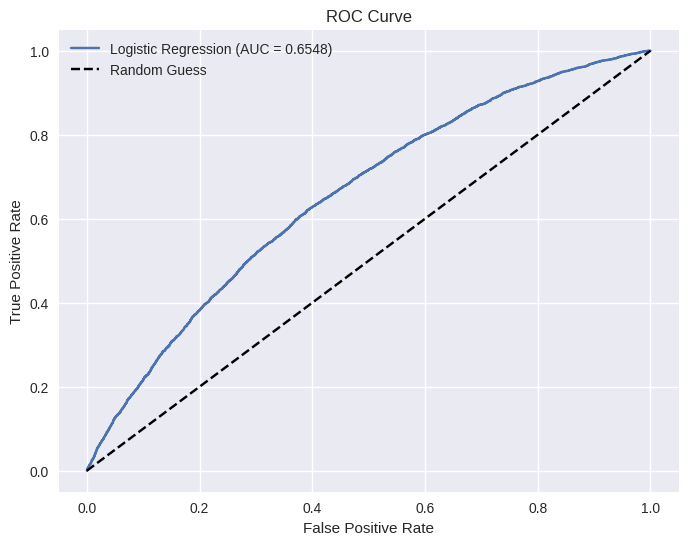

In [177]:
X = train_data_standardized.drop(columns=['IS_BOUND'])
y = train_data_standardized['IS_BOUND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Prediction

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities

# Calculate ROC curve values: FPR, TPR, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Calculate AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_proba)
print("AUC-ROC Score:", auc_score)
# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
TN, FP = confusion_matrix(y_test, y_pred)[0]
FN, TP = confusion_matrix(y_test, y_pred)[1]
profit = TP * 5.5 + (FP + TP) * -1
print(f"Profit: {profit}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Model Tuning

In [179]:
def log_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
    model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]


    matrix = confusion_matrix(y_test, y_pred)
    accuracyScore = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    TN, FP = matrix[0]
    FN, TP = matrix[1]
    profit = (TP * 5.5 + (FP + TP) * -1) / len(y_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Average Profit: {profit}")


    y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities

    # Calculate ROC curve values: FPR, TPR, and threshold values
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    # Calculate AUC (Area Under the Curve)
    auc_score = roc_auc_score(y_test, y_proba)
    print("AUC-ROC Score:", auc_score)
    # Calculate F1 Score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for random guess
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return accuracyScore, auc_score, f1, profit

### Class Resampling

Accuracy: 0.7025087642418931
Confusion Matrix:
 [[4703 2228]
 [3203 8122]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.68      0.63      6931
         1.0       0.78      0.72      0.75     11325

    accuracy                           0.70     18256
   macro avg       0.69      0.70      0.69     18256
weighted avg       0.71      0.70      0.71     18256

Average Profit: 1.8799846625766872
AUC-ROC Score: 0.762003335941827
F1 Score: 0.749434832756632


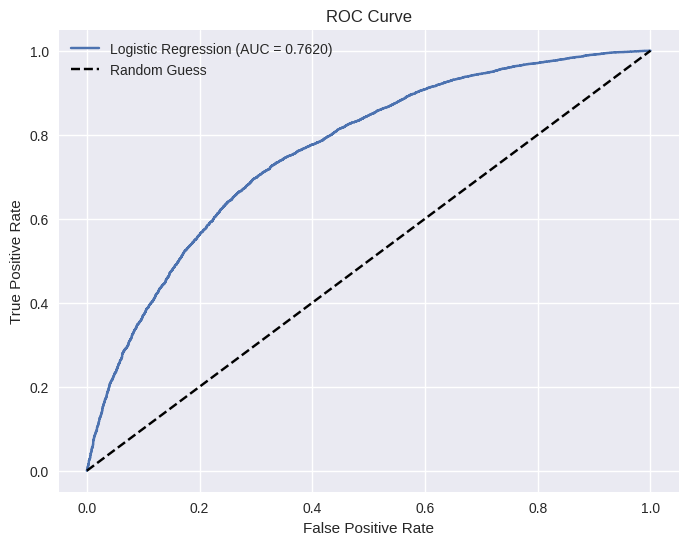

(0.7025087642418931, 0.762003335941827, 0.749434832756632, 1.8799846625766872)

In [180]:
# Apply SMOTE and Edited Nearest Neighbors (SMOTEENN)
X = train_data_standardized.drop(columns=['IS_BOUND'])
y = train_data_standardized['IS_BOUND']
smoteenn = SMOTEENN()
X_resampled, y_resampled = smoteenn.fit_resample(X, y)

log_reg(X_resampled, y_resampled)

### PCA

In [187]:
# Set info limit to 95%
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_resampled)

print("Number of components:", pca.n_components_)

Number of components: 98


Accuracy: 0.6967572304995618
Confusion Matrix:
 [[4750 2181]
 [3355 7970]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.69      0.63      6931
         1.0       0.79      0.70      0.74     11325

    accuracy                           0.70     18256
   macro avg       0.69      0.69      0.69     18256
weighted avg       0.71      0.70      0.70     18256

Average Profit: 1.8450920245398772
AUC-ROC Score: 0.7528684354101594
F1 Score: 0.7422238778170982


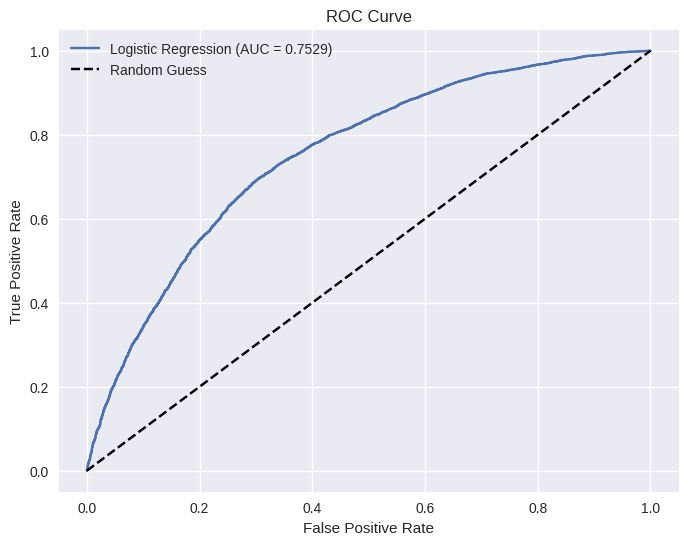

(0.6967572304995618,
 0.7528684354101594,
 0.7422238778170982,
 1.8450920245398772)

In [188]:
X = X_pca
y = y_resampled

log_reg(X, y)

### Forward Selection

In [ ]:
X = pd.DataFrame(X_pca)
y = y_resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(solver='liblinear')

selected_features = []
best_precision = 0
remaining_features = list(range(X_train.shape[1]))

# Iterate over the remaining features
while remaining_features:
    precision_scores = []

    # Try adding each remaining feature and evaluate model precision on 1s
    for feature in remaining_features:
        features_to_test = selected_features + [feature]
        # Use .iloc for integer-based indexing
        X_train_subset = X_train.iloc[:, features_to_test]

        # Fit the model and calculate precision on 1s (positive class)
        model.fit(X_train_subset, y_train)
        # Use .iloc for integer-based indexing
        y_pred = model.predict(X_test.iloc[:, features_to_test])
        precision = precision_score(y_test, y_pred, pos_label=1)

        precision_scores.append((precision, feature))

    # Select the feature that improves precision the most
    precision_scores.sort(reverse=True, key=lambda x: x[0])  # Sort by precision

    best_precision_score, best_feature = precision_scores[0]

    if best_precision_score > best_precision:
        selected_features.append(best_feature)  # Add the best feature to the selected set
        best_precision = best_precision_score  # Update the best precision
        remaining_features.remove(best_feature)  # Remove the selected feature from remaining features
        print(f"Selected Features: {selected_features}")
        print(f"Best Precision: {best_precision}")
    else:
        break

X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

model.fit(X_train_selected, y_train)
y_pred_final = model.predict(X_test_selected)

# Calculate final precision on 1s (positive class)
final_precision = precision_score(y_test, y_pred_final, pos_label=1)
print(f'Final precision on 1s: {final_precision}')
print(f'Selected Features: {selected_features}')

Selected Features: [8]
Best Precision: 0.6428960261295591
Selected Features: [8, 16]
Best Precision: 0.6544834307992202
Selected Features: [8, 16, 3]
Best Precision: 0.6657559853332374
Selected Features: [8, 16, 3, 6]
Best Precision: 0.6730054644808743
Selected Features: [8, 16, 3, 6, 0]
Best Precision: 0.6785555060187249
Selected Features: [8, 16, 3, 6, 0, 22]
Best Precision: 0.6843615494978479
Selected Features: [8, 16, 3, 6, 0, 22, 13]
Best Precision: 0.6868043294695633
Selected Features: [8, 16, 3, 6, 0, 22, 13, 57]
Best Precision: 0.6879667410886134
Selected Features: [8, 16, 3, 6, 0, 22, 13, 57, 77]
Best Precision: 0.6888359218822082
Selected Features: [8, 16, 3, 6, 0, 22, 13, 57, 77, 17]
Best Precision: 0.6897108581974777
Selected Features: [8, 16, 3, 6, 0, 22, 13, 57, 77, 17, 69]
Best Precision: 0.6902579899884482
Selected Features: [8, 16, 3, 6, 0, 22, 13, 57, 77, 17, 69, 61]
Best Precision: 0.6907391673746814
Selected Features: [8, 16, 3, 6, 0, 22, 13, 57, 77, 17, 69, 61, 4]


### Hyperparameter Tuning

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score

X = X_pca
y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # You can extend or modify this range

# Step 2: Create a Logistic Regression model
log_reg = LogisticRegression(solver='liblinear')

# Step 3: Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

# Step 4: Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Step 5: Get the best C value and corresponding model
best_C = grid_search.best_params_['C']
print(f"Best C Value: {best_C}")

# Step 6: Train the Logistic Regression model with the best C value
log_reg_best = LogisticRegression(C=best_C, solver='liblinear')
log_reg_best.fit(X_train, y_train)

# Step 7: Make predictions and evaluate the model
y_pred = log_reg_best.predict(X_test)

# Evaluate precision on positive class
precision = precision_score(y_test, y_pred)
print(f"Precision on 1s (Positive Class): {precision}")

# Optionally: You can also check the best score from GridSearchCV
print(f"Best Grid Search Score: {grid_search.best_score_}")

Best C Value: 10
Precision on 1s (Positive Class): 0.7278495354634036
Best Grid Search Score: 0.7279926620941013


### Threshold

Accuracy: 0.7021801051709027
Confusion Matrix:
 [[4732 2199]
 [3238 8087]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.68      0.64      6931
         1.0       0.79      0.71      0.75     11325

    accuracy                           0.70     18256
   macro avg       0.69      0.70      0.69     18256
weighted avg       0.71      0.70      0.71     18256



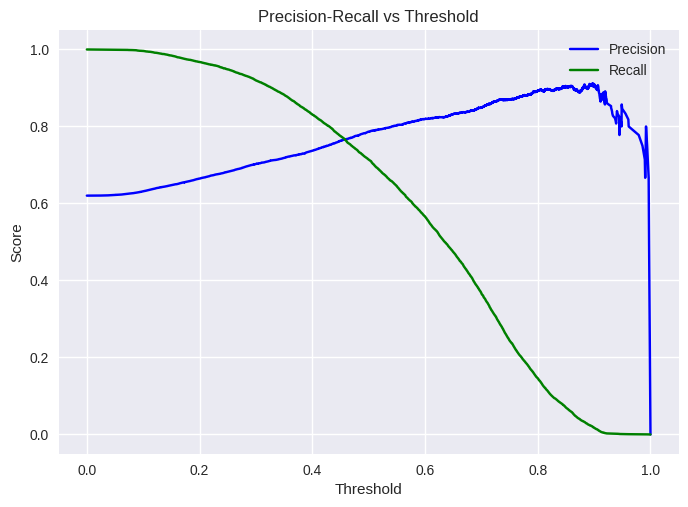

In [192]:
X = X_pca
y = y_resampled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(class_weight="balanced", C = 10, random_state=89, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Prediction

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities


precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.show()

## Final Model

In [193]:
optimal_threshold = 0.45
model = LogisticRegression(class_weight="balanced", C = 10, random_state=89, max_iter=1000)
model.fit(X_pca, y_resampled)
# Predict probabilities for the test set

X_test = pca.transform(test_data_standardized)
y_proba = model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

list_predictions =y_pred_optimal.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]
print(rounded_list_predictions)

[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 

# Modelling Method 2 - Random Forests

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.5, random_state=42)

## Random Forest

## Fitting Original Model

Accuracy: 0.7382112866286922


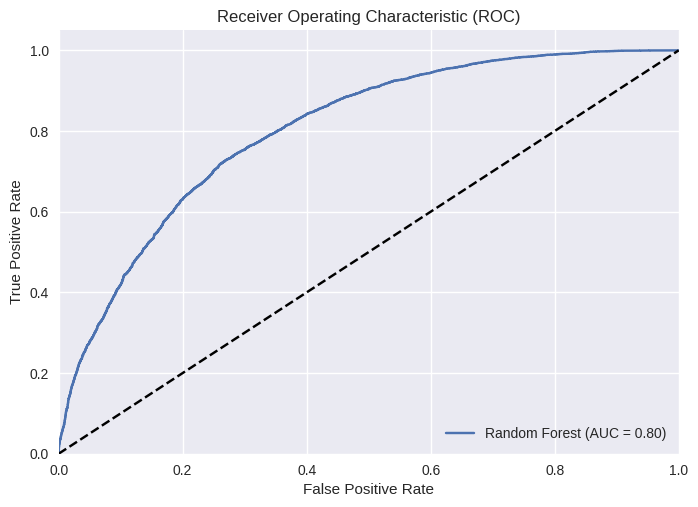

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split data with important features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a new RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split=5, min_samples_leaf=1, max_depth=10)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate ROC curve and AUC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

0.26178871337130777

## Prediction Analysis

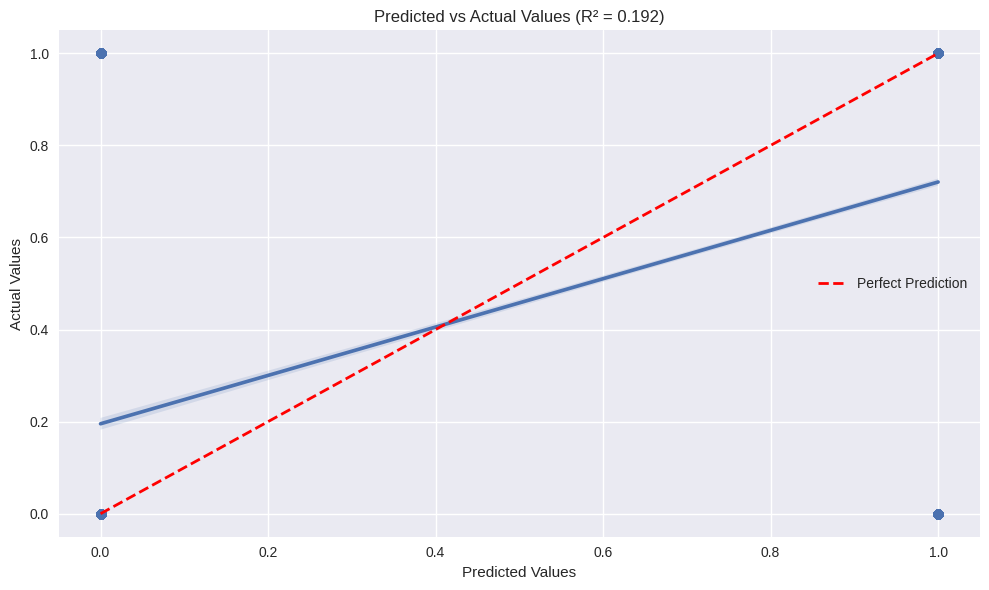

In [ ]:
def plot_prediction_analysis(y_test, y_pred):
    # Calculate R-squared
    r2 = np.corrcoef(y_test, y_pred)[0,1]**2

    # Create figure
    plt.figure(figsize=(10, 6))

    # Create regression plot
    sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.5})

    # Add perfect prediction line
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')

    # Add labels and title
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(f'Predicted vs Actual Values (R² = {r2:.3f})')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Use it like this:
plot_prediction_analysis(y_test, y_pred)

In [ ]:
insurance_rf = RandomForestRegressor(max_features=6, random_state=42, n_estimators=100)
insurance_rf.fit(X_train, y_train)

y_pred = insurance_rf.predict(X_test)

mean_squared_error(y_test, y_pred)

0.07764743085325033

## Model Tuning

### Important Features

In [ ]:
def plot_feature_importances(model, feature_names, x_tick_rotation=45, threshold=0.01):
    # Get feature importances
    importances = pd.Series(model.feature_importances_, index=feature_names)

    # Filter features above threshold
    importances = importances[importances >= threshold]

    # Sort in descending order
    importances = importances.sort_values(ascending=False)

    # Create figure
    plt.figure(figsize=(10, 6))

    # Create bar plot
    importances.plot(kind='bar')

    # Add labels and title
    plt.title(f'Feature Importances (threshold >= {threshold})')
    plt.xlabel('Features')
    plt.ylabel('Importance')

    # Rotate x-axis labels
    plt.xticks(rotation=x_tick_rotation, ha='right')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    plt.show()

    # Print sorted importances
    print("\nFeature Importances:")
    for name, importance in importances.items():
        print(f"{name}: {importance:.4f}")

# Use it like this:
plot_feature_importances(rfi_model, X.columns, x_tick_rotation=45, threshold=0.01)

NameError: name 'rfi_model' is not defined

In [ ]:
# Get important features (e.g., those with importance > threshold)
threshold = 0.01  # adjust this based on your needs
important_features = pd.Series(insurance_rf.feature_importances_, index=X.columns)
important_features = important_features[important_features > threshold].index

# Create new dataset with only important features
X_important = X[important_features]

# # Train new model with important features only
# model_important = rfi(random_state=42)  # or your chosen model
# model_important.fit(X_important, y)

### Fitting Feature Selected Model

In [ ]:
#rom sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split data with important features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

# Initialize a new RandomForestClassifier
rfi_model = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split=5, min_samples_leaf=1, max_depth=10)

# Train the model on the training data
rfi_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rfi_model.predict(X_test)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate ROC curve and AUC
y_pred_proba = rfi_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Original model performance
scores_original = cross_val_score(rf_model, X, y, cv=5)

# New model performance with important features only
scores_important = cross_val_score(rfi_model, X_important, y, cv=5)

print("Original model CV scores:", scores_original.mean(), "±", scores_original.std())
print("Important features model CV scores:", scores_important.mean(), "±", scores_important.std())

In [ ]:
# if len(important_features) >= 2:
#     top_2_features = important_features[:2]
#     X_important[f'{top_2_features[0]}_x_{top_2_features[1]}'] = (
#         X_important[top_2_features[0]] * X_important[top_2_features[1]]
#     )

### Hyper-Parameter Tuning

In [ ]:
# prompt: use RandomizedSearchCV for hyperparamter tuning

from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rfi_model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Use the best model for prediction
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

### Adjusting Threshold for Revenue Maximizing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict probabilities for the positive class
y_probs = best_rf_model.predict_proba(X_test)[:, 1]

# Define a range of thresholds
thresholds = np.arange(0.0, 1.0, 0.01)
false_positive_rates = []
false_negative_rates = []
revenues = []

# Calculate FPR, FNR, and revenue for each threshold
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test[:len(y_pred)], y_pred).ravel()

    # Calculate false positive rate and false negative rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Append FPR and FNR to lists
    false_positive_rates.append(fpr)
    false_negative_rates.append(fnr)

    # Calculate revenue: (5.5 * True Positives) - (1 * Predicted Positives)
    revenue = (5.5 * tp) - (1 * (tp + fp))
    revenues.append(revenue)

# Plotting FPR and FNR against thresholds
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot false positive and false negative rates
ax1.plot(thresholds, false_positive_rates, label="Probability of False Positives (FP)", color="green")
ax1.plot(thresholds, false_negative_rates, label="Probability of False Negatives (FN)", color="blue")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Probability")
ax1.set_title("Probability of False Negatives (FN), False Positives (FP), and Revenue by Threshold")
ax1.grid()
ax1.legend(loc="upper left")

# Plot revenue on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(thresholds, revenues, label="Revenue", color="orange")
ax2.set_ylabel("Revenue ($)")
ax2.legend(loc="upper right")

# Mark the Equal Error Point (EEP) where FP and FN rates intersect
equal_error_point = thresholds[np.argmin(np.abs(np.array(false_positive_rates) - np.array(false_negative_rates)))]
ax1.axvline(equal_error_point, color="red", linestyle="--", label="Equal Error Point (EEP)")
ax1.legend(loc="upper left")

plt.show()

print(f"Equal Error Point (EEP) Threshold: {equal_error_point}")


### Predicting with Final Model

This model has an advertising revenue of 12 on the leaderboard

In [ ]:

# Align test data columns with training data
test_data_standardized = test_data_standardized.reindex(columns=X.columns, fill_value=0)

# Get probabilities for the positive class (ISBOUND=1)
probabilities = rf_model.predict_proba(test_data_standardized)[:, 1]

# Apply the EEP threshold
threshold = 0.21
predictions = (probabilities >= threshold).astype(int)

# Convert predictions to a list
list_predictions = predictions.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]

# Output predictions
print("Predictions:", rounded_list_predictions)
print("Number of predictions:", len(rounded_list_predictions))
